In [1]:
import io
import json
import os
import warnings

import gprofiler
import matplotlib.pyplot as plt
import natsort
import networkx as nx
import numpy as np
import pandas as pd
import pyteomics.auxiliary
import pyteomics.fasta
import requests
import seaborn as sns
import tqdm
from chembl_webresource_client.new_client import new_client as chembl_client

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)
tqdm.tqdm.pandas()

# Investigation of SARS-CoV-2 virus-host protein-protein interactions

This notebook forms a brief tutorial of the computational steps needed to analyze affinity purification mass spectrometry (AP-MS) data to detect protein-protein interactions (PPIs).

We will reanalyze AP-MS data generated by [Gordon et al.](https://doi.org/10.1038/s41586-020-2286-9) to investigate the SARS-CoV-2 virus-host interactome.

This notebook is expected to be present in a subdirectory of the working directory (arbitrary, `notebooks` recommended). The data will be stored in the `data` subdirectory. The bioinformatics tools to be used need to be  in the `bin` subdirectory or installed and present on the `$PATH`.

## Download data

The raw SARS-CoV-2 AP-MS data is available on [PRIDE](https://www.ebi.ac.uk/pride/) with project number [PXD018117](https://www.ebi.ac.uk/pride/archive/projects/PXD018117), and is also available on [MassIVE](https://massive.ucsd.edu/ProteoSAFe/static/massive.jsp) with accession [MSV000085144](https://massive.ucsd.edu/ProteoSAFe/dataset.jsp?task=562750f9c63f4796bf85d6d979f54da1). The data consists of 98 RAW files corresponding to AP-MS runs for the SARS-CoV-2 proteins expressed in human cells and measured in biological triplicate, and the FASTA files used for spectral identification.

The data will be downloaded to the `external` subdirectory of the `data` directory.

In [3]:
%%bash

if [ ! -d ../data/external/PXD018117 ]; then
    wget --timestamping --retry-connrefused \
        --directory-prefix=../data/external/PXD018117 --passive-ftp \
        ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2020/03/PXD018117/*
fi

## Spectrum identification

After downloading the data, we will first convert the RAW files to MGF files using [ThermoRawFileParser](https://github.com/compomics/ThermoRawFileParser) for easy cross-platform analysis.

The MGF files will be stored in the `interim` subdirectory of the `data` directory.

In [4]:
%%bash

mkdir -p ../data/interim/PXD018117

for raw_file in ../data/external/PXD018117/*.raw; do
    if [ ! -f ../data/interim/PXD018117/$(basename $raw_file .raw).mgf ]; then
        mono ThermoRawFileParser.exe -i $raw_file -o ../data/interim/PXD018117 -f 0
    fi
done

The AP-MS data contains spectra corresponding to three different species: human, SARS-CoV-2, and green fluorescent protein (tag used for AP-MS). The corresponding three FASTA files downloaded from PRIDE (in the `external` subdirectory) are concatenated into a single FASTA file for spectral identification (in the `interim` subdirectory).

In [5]:
! cat ../data/external/PXD018117/*.fasta > ../data/interim/PXD018117/human_GFP_SARSCoV2.fasta

Next, we identify the MS/MS spectra using sequence database searching. We use the [Comet](http://comet-ms.sourceforge.net/) search engine via the [Crux](http://crux.ms/) toolkit.

The following settings are used for spectral identification:

- Concatenated target-decoy search.
- 10 _m_/_z_ precursor mass tolerance.
- Trypsin/P cleavage.
- Remove precursor peak.
- Only report the top scoring peptide per spectrum.
- All other settings were kept at their [default values](http://crux.ms/commands/comet.html).

In [6]:
%%bash

for mgf_file in ../data/interim/PXD018117/*.mgf; do
    if [ ! -f ../data/processed/PXD018117/$(basename $mgf_file .mgf).comet.target.txt ]; then
        crux comet $mgf_file ../data/interim/PXD018117/human_GFP_SARSCoV2.fasta \
            --decoy_search 1 --peptide_mass_tolerance 10 --peptide_mass_units 2 \
            --search_enzyme_number 2 --remove_precursor_peak 1 \
            --fileroot $(basename $mgf_file .mgf) \
            --output-dir ../data/processed/PXD018117 --output_pepxmlfile 0 \
            --num_output_lines 1
    fi
done

## PPI generation

The outcome of a PPI experiment is a list of bait proteins (the SARS-CoV-2 proteins) and their potential interaction partners (preys). However, such unfiltered lists can contain a very high number of false positive interactions which need to be filtered out.

First, to avoid false positive interactions arising from incorrect protein identifications we will filter the identifications at the spectrum level and the protein level based on the target-decoy search strategy.
Second, we will remove nonspecific interactors by estimating the background of identified proteins over multiple unrelated MS runs in the AP-MS experiment, with proteins that are present at a higher abundance than the background assumed to be interactors.

### Filter PSMs on FDR

We will process the peptide-spectrum matches (PSMs) in Python to filter them at a 1% PSM and protein level false discovery rate (FDR).

PSMs are read from the different Comet output files (excluding failed runs as documented by Gordon et al.) and [Pyteomics](https://pyteomics.readthedocs.io/en/latest/) is used for FDR filtering.

In [7]:
psm_fdr = protein_fdr = 0.01

In [8]:
# Read all PSMs from the Comet output files (excluding failed runs) into a
# Pandas data frame.
ignore_runs = set(['qx017094', 'qx017095', 'qx017096',
                   'qx017200', 'qx017201', 'qx017202'])
psms = []
id_dir = '../data/processed/PXD018117'
for filename in os.listdir(id_dir):
    filebase, ext = filename.split('.', 1)
    if ext == 'comet.target.txt' and filebase not in ignore_runs:
        file_psms = pd.read_csv(
            os.path.join(id_dir, filename), sep='\t',
            usecols=['scan', 'charge', 'spectrum precursor m/z',
                     'xcorr score', 'sequence', 'protein id'])
        file_psms['filename'] = filebase
        psms.append(file_psms)
psms = pd.concat(psms, ignore_index=True)[[
    'filename', 'scan', 'spectrum precursor m/z', 'charge', 'sequence',
    'protein id', 'xcorr score']]

In [9]:
# Add protein information to the PSMs and split per individual proteins.
psms['protein id'] = psms['protein id'].str.split(',')
psms = psms.explode('protein id')
psms['is_decoy'] = psms['protein id'].str.startswith('decoy_')
psms['protein_short'] = [protein[1] if len(protein) > 1 else protein[0]
                         for protein in psms['protein id'].str.split('|')]
print(f'Number of PSMs before FDR filtering: {len(psms):,}')
# PSM level FDR filtering.
psms_filtered = pyteomics.auxiliary.target_decoy.filter(
    psms, fdr=psm_fdr, key='xcorr score', reverse=True, is_decoy='is_decoy',
    remove_decoy=False, formula=1, correction=1)
print(f'Number of PSMs after PSM-level FDR filtering: '
      f'{len(psms_filtered):,}')
# Protein level FDR filtering.
proteins = (psms_filtered.groupby('protein id')['xcorr score'].max()
            .reset_index())
proteins['is_decoy'] = proteins['protein id'].str.startswith('decoy_')
proteins_filtered = pyteomics.auxiliary.target_decoy.filter(
    proteins, fdr=protein_fdr, key='xcorr score', reverse=True,
    is_decoy='is_decoy', formula=1, correction=1)
psms_filtered = psms_filtered[psms_filtered['protein id'].isin(
    proteins_filtered['protein id'].unique())]
print(f'Number of PSMs after protein-level FDR filtering: '
      f'{len(psms_filtered):,}')

Number of PSMs before FDR filtering: 2,440,230
Number of PSMs after PSM-level FDR filtering: 182,924
Number of PSMs after protein-level FDR filtering: 173,748


In [10]:
# Export PSMs for upload to MassIVE.
psms_export = (psms_filtered.copy()
               .drop(columns=['is_decoy', 'protein_short'])
               .sort_values(['filename', 'scan']))
psms_export['filename'] = psms_export['filename'] + '.raw'
psms_export.to_csv('../data/processed/psms_filtered.csv', sep='\t',
                   columns=['filename', 'scan', 'sequence', 'protein id',
                            'charge', 'q'],
                   index=False)

### Generate SAINTexpress input files

We will use the [SAINTexpress](saint-apms.sourceforge.net/Main.html) tool to detect high-confidence PPIs.
SAINTexpress uses label-free quantification data to assign confidence scores to PPIs.

SAINTexpress requires three tab-separated text input files: a bait file, a prey file, and an interaction file. These files will be stored in the `processed` subdirectory of the `data` directory.

In [11]:
sample_annotation = pd.read_excel(
    '../data/external/PXD018117/SARS ProteomeXchange Upload Sample Annotations.xlsx',
    index_col='QX raw file ID')

#### Bait file

The bait file should have three columns: run name, bait name, and an indicator whether the run was a test (T) or negative control (C) run. We extract this information from the experiment metadata spreadsheet downloaded from PRIDE and export it to a text file.

Below, you can see three biological replicates for the SARS-CoV-2 E, M, and N proteins, and several negative control runs.

In [12]:
columns = ['Sample ID', 'Condition', 'Control (C), or SARS-CoV-2 Bait (T)']
baits = (sample_annotation.sort_values(columns)[columns]
         .rename(columns={'Sample ID': 'run_name',
                          'Condition': 'bait_name',
                          'Control (C), or SARS-CoV-2 Bait (T)': 'run_type'}))
baits.to_csv('../data/processed/bait.txt', sep='\t', header=False, index=False)
baits.sort_values('bait_name').reset_index(drop=True).head(20)

,run_name,bait_name,run_type
0,CoV01-002_H11,E,T
1,CoV01-031_F6,E,T
2,CoV01-025_F12,E,T
3,CoV02-005,EGFP,C
4,CoV02-004,EGFP,C
5,CoV01-039_E10,EGFP,C
6,CoV01-013_G12,EGFP,C
7,CoV02-003,EV,C
8,CoV02-002,EV,C
9,CoV02-001,EV,C


#### Prey file

The prey file should have three columns: prey (protein) name, protein length, and gene name.

To create a relevant prey file we extract the protein information from the previously downloaded FASTA files using Pyteomics, filter this to only include information for the proteins that have been identified, and export it to a text file.

In [13]:
preys = []
for filename in ['uniprot-reviewed-human-canonical-20200228.fasta',
                 'GFP.fasta']:
    for header, sequence in pyteomics.fasta.read(
            os.path.join('../data/external/PXD018117/', filename),
            flavor='uniprot'):
        preys.append([header['id'], len(sequence),
                      header.get('GN', header['gene_id'])])
for header, sequence in pyteomics.fasta.read(
        '../data/external/PXD018117/SARS-CoV-2_FASTA_20200305.fasta'):
    preys.append([header, len(sequence), header[header.rfind('_') + 1:]])
preys = (pd.DataFrame(preys, columns=['prey_name', 'protein_length', 'gene'])
         .set_index('prey_name')
         .reindex(psms_filtered['protein_short'].unique())
         .reset_index().sort_values('prey_name').dropna())
preys['protein_length'] = preys['protein_length'].astype(int)
preys.to_csv('../data/processed/prey.txt', sep='\t', header=False, index=False)
preys.reset_index(drop=True).head()

,prey_name,protein_length,gene
0,A0A0U1RRE5,68,NBDY
1,A0A1B0GUS4,154,UBE2L5
2,A0FGR8,921,ESYT2
3,A0JLT2,244,MED19
4,A0PK00,339,TMEM120B


#### Interaction file

The interaction file should contain four columns: run name, bait name, prey name, and label-free quantification (LFQ) data. The run names and the bait names should match the run names and the bait names in the first two columns of the bait file and the prey names should match the prey names in the first column of the prey file.

For the LFQ data we will use spectral counts, i.e. how many MS/MS spectra that were identified map to the proteins. The interaction file should not contain interactions with zero counts.

In [14]:
inter = (psms_filtered.groupby(['filename', 'protein_short'])
         ['protein_short'].count().to_frame()
         .rename(columns={'protein_short': 'count'})
         .reset_index()
         .rename(columns={'protein_short': 'prey_name'}))
inter = (pd.merge(inter, baits[['run_name', 'bait_name']],
                  left_on='filename', right_index=True)
         [['run_name', 'bait_name', 'prey_name', 'count']]
         .sort_values(['run_name', 'bait_name', 'prey_name']))
# Remove the baits themselves as preys.
inter = inter[~inter.apply(
    lambda row: row['prey_name'].split('_')[-1].endswith(
        row['bait_name'].split('_')[0]), axis=1)]
inter.to_csv('../data/processed/inter.txt', sep='\t', header=False, index=False)
inter.reset_index(drop=True).head()

,run_name,bait_name,prey_name,count
0,CoV01-002_H11,E,A5A3E0,1
1,CoV01-002_H11,E,A6NHL2,1
2,CoV01-002_H11,E,A6NNZ2,2
3,CoV01-002_H11,E,B2RPK0,1
4,CoV01-002_H11,E,O00203,1


### PPI filtering using SAINTexpress

Next, PPIs are scored using SAINTexpress and only the high-confidence interactions are retained.

Depending on whether spectral counting or MS1 intensity LFQ data is used as input for SAINTexpress, the `SAINTexpress-spc` or `SAINTexpress-int` executable should be used respectively.

In [15]:
ppi_fdr = 0.01
ppi_num_spectra = 20

In [16]:
%%bash

if [ ! -f ../data/processed/list.txt ]; then
    ../bin/SAINTexpress_v3.6.3__2018-03-09/bin/SAINTexpress-spc \
        ../data/processed/inter.txt \
        ../data/processed/prey.txt \
        ../data/processed/bait.txt
    mv list.txt ../data/processed/list.txt
fi

An example of the SAINTexpress output is shown below. It consists of a tab-separated file containing bait–prey combinations, their spectral counts, SAINT score, and FDR.

In [17]:
ppis = pd.read_csv('../data/processed/list.txt', sep='\t')
ppis_filtered = ppis[(ppis['BFDR'] <= ppi_fdr) &
                     (ppis['SpecSum'] >= ppi_num_spectra)].copy()
ppis_filtered.reset_index(drop=True).head()

,Bait,Prey,PreyGene,Spec,SpecSum,AvgSpec,NumReplicates,ctrlCounts,AvgP,MaxP,TopoAvgP,TopoMaxP,SaintScore,logOddsScore,FoldChange,BFDR,boosted_by
0,M,A6NNZ2,TUBB8B,12|6|8,26,8.67,3,3|1|0|2|1|1|0|1|2|0|1,0.98,1.0,0.98,1.0,0.98,2.84,7.94,0.0,NaN
1,M,O00410,IPO5,7|6|7,20,6.67,3,0|0|0|0|0|0|0|0|0|0|0,1.00,1.0,1.00,1.0,1.00,9.89,66.67,0.0,NaN
2,M,O14980,XPO1,12|9|6,27,9.00,3,0|0|0|0|0|0|0|0|0|0|0,1.00,1.0,1.00,1.0,1.00,9.89,90.00,0.0,NaN
3,M,O43175,PHGDH,12|10|9,31,10.33,3,2|1|0|0|1|2|1|2|1|1|0,1.00,1.0,1.00,1.0,1.00,6.96,10.33,0.0,NaN
4,M,O43592,XPOT,13|6|9,28,9.33,3,0|0|0|0|0|0|0|0|0|0|0,1.00,1.0,1.00,1.0,1.00,9.89,93.33,0.0,NaN


We only retain PPIs below 1% FDR and with at least 20 spectra observed, which reduces the number of PPIs 100-fold.

In [18]:
print(f'Number of potential PPIs: {len(inter):,}')
print(f'Number of PPIs at {ppi_fdr:.0%} FDR: {len(ppis_filtered):,}')

Number of potential PPIs: 44,992
Number of PPIs at 1% FDR: 412


### Comparison to original study

In their original results Gordon et al. report 332 high-confidence PPIs, slightly below the 412 PPIs that are reported here. The discrepancy can largely be explained by differences in PPI filtering: Gordon et al. have used a two-step combination of SAINTexpress and [MiST](https://modbase.compbio.ucsf.edu/mist/) with varying thresholds to detect high-confidence PPIs as opposed to the SAINTexpress FDR threshold and minimum spectrum count employed here.

When not taking into account score thresholds in the PPI data reported by Gordon et al., 319 of 412 PPIs overlap. The remaining difference in PPIs can be attributed to different search engines that were used for spectrum identification (MaxQuant versus Comet).

In [19]:
ppis_orig_filtered = pd.read_excel(
    'https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2286-9/'
    'MediaObjects/41586_2020_2286_MOESM6_ESM.xlsx',
    header=1, usecols=['Bait', 'Preys']).rename(columns={'Preys': 'Prey'})
ppis_orig_filtered['Bait'] = (ppis_orig_filtered['Bait']
                              .str.replace('SARS-CoV2 ', '')
                              .replace({'Spike': 'S'}))

In [20]:
ppis_orig = pd.read_excel(
    'https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2286-9/'
    'MediaObjects/41586_2020_2286_MOESM5_ESM.xlsx',
    usecols=['Bait', 'Preys', 'Saint_BFDR', 'MIST']).rename(
    columns={'Preys': 'Prey'})
ppis_orig['Bait'] = (ppis_orig['Bait'].str.replace('SARS-CoV2 ', '')
                     .replace({'Spike': 'S'}))

In [21]:
print(f'Overlap with filtered PPIs Gordon et al.: '
      f'{len(pd.merge(ppis_filtered, ppis_orig_filtered, on=["Bait", "Prey"]))}')
print(f'Overlap with unfiltered PPIs Gordon et al.: '
      f'{len(pd.merge(ppis_filtered, ppis_orig, on=["Bait", "Prey"]))}')

Overlap with filtered PPIs Gordon et al.: 53
Overlap with unfiltered PPIs Gordon et al.: 319


### GO analysis

We can perform a gene ontology (GO) enrichment analysis to get insight into how SARS-CoV-2 subverts molecular processes. We perform a GO enrichment analysis for the human protein targets per SARS-CoV-2 bait among the 93 newly detected virus-host interactions using [g:Profiler](https://biit.cs.ut.ee/gprofiler/). GO biological process terms are evaluated with a p value threshold of $0.01$ after g:SCS multiple testing correction.

In [22]:
ppis_new = (pd.merge(ppis_filtered, ppis_orig, on=['Bait', 'Prey'])
            .set_index(['Bait', 'Prey']))
ppis_new = ppis_filtered[~ppis_filtered.set_index(['Bait', 'Prey'])
                         .index.isin(ppis_new.index)]

fdr_threshold = 0.01
go_enrichment = gprofiler.GProfiler(return_dataframe=True).profile(
    ppis_new.groupby('Bait')['Prey'].apply(
        lambda preys: preys.unique().tolist()).to_dict(),
    'hsapiens', ['GO:BP'], fdr_threshold,
    significance_threshold_method='g_SCS')
go_enrichment = (go_enrichment[['query', 'native', 'name', 'p_value']]
                 .rename(columns={
                     'query': 'Virus protein', 'native': 'GO term',
                     'name': 'Name', 'p_value': 'p value'})
                 .sort_values(['Virus protein', 'GO term']))

In [23]:
go_enrichment.head()

,Virus protein,GO term,Name,p value
39,nsp10,GO:0006457,protein folding,0.001089
4,nsp10,GO:0006458,'de novo' protein folding,0.000005
29,nsp10,GO:0006986,response to unfolded protein,0.000632
58,nsp10,GO:0007020,microtubule nucleation,0.005280
41,nsp10,GO:0009266,response to temperature stimulus,0.001258


## Drug repurposing

Drug repurposing is an especially attractive strategy in the early phase of an epidemic to provide immediate treatment. The advantage of repurposing existing drugs is that no expensive and time-consuming drug development cycle has to be completed but that the drugs are readily available. Additionally, existing drugs have known safety profiles and are already familiar to clinicians working with these drugs.

Here we show how to use the ChEMBL Python client to find existing FDA-approved drug compounds that target host proteins that interact with SARS-CoV-2 proteins. Our query finds human proteins (*targets*) that include *mechanisms* of action for FDA-approved drugs and retrieves the corresponding *compounds*.

In [24]:
def _chembl_drugs_for_target(protein):
    drug_names = set()
    for target in chembl_client.target.filter(
            target_components__accession=protein):
        for mechanism in chembl_client.mechanism.filter(
                target_chembl_id=target['target_chembl_id']):
            for compound in chembl_client.compound_record.filter(
                    molecule_chembl_id=mechanism['molecule_chembl_id']):
                compound_name = (compound['compound_name']
                                 if compound['compound_name'] is not None
                                 else compound['compound_key'])
                drug_names.add(compound_name.lower())
    return list(drug_names)

In [25]:
ppis_filtered['Drug'] = ppis_filtered['Prey'].progress_apply(
    _chembl_drugs_for_target)

100%|██████████| 412/412 [00:09<00:00, 41.61it/s]


We find 2982 drug–protein pairs consisting of 51 unique human proteins that are targeted by 357 unique drugs.

In [26]:
drugs = (ppis_filtered.explode('Drug').dropna(subset=['Drug'])
         .drop_duplicates(['PreyGene', 'Drug']).reset_index(drop=True)
         [['Bait', 'Prey', 'PreyGene', 'Drug']])
drugs.head()

,Bait,Prey,PreyGene,Drug
0,M,O14980,XPO1,selinexor
1,M,O14980,XPO1,selinexor (kpt-330)
2,M,O14980,XPO1,kpt-330
3,M,P04350,TUBB4A,ixabepilone (bms-247550)
4,M,P04350,TUBB4A,"sodium(z)-2-methoxy-5-(3,4,5-trimethoxystyryl)..."


In [27]:
print(f'Number of drug-protein pairs: {len(drugs)}')
print(f'Number of unique drug targets: {drugs["Prey"].nunique()}')
print(f'Number of unique drugs: {drugs["Drug"].nunique()}')

Number of drug-protein pairs: 2982
Number of unique drug targets: 51
Number of unique drugs: 357


### Drugs in clinical trials

We referenced the drugs that were identified to target human proteins involved in virus-host interactions against SARS-CoV-2 clinical trials registered at [ClinicalTrials.gov](https://www.clinicaltrials.gov/).

This indicates that currently four different drugs are being considered in active clinical trials. These 
include colchicine, an anti-inflammatory drug which has been shown to improve time to clinical deterioration; cd24fc, which has immune checkpoint inhibitory and anti-inflammatory activities and which was originally developed for the treatment of graft-versus-host disease; and selinexor, an anticancer drug that blocks the cellular protein XPO1, which mediates the export of viral proteins out of the nucleus.

This demonstrates how the study of virus-host interactions can lead to mechanistic insights into viral infection to identify host proteins that can be used as potential targets for drug repurposing.

In [28]:
request = requests.get('https://clinicaltrials.gov/api/query/field_values?'
                       'expr=COVID-19&field=InterventionName&fmt=json')
clinical_trials_interventions = json.loads(request.content)
clinical_trials_drugs = set([
    intervention['FieldValue'].lower()
    for intervention in (clinical_trials_interventions
                         ['FieldValuesResponse']['FieldValues'])])

In [29]:
ppis_overlap = pd.merge(ppis_filtered, ppis_orig_filtered, 'left',
                        ['Bait', 'Prey'], indicator=True)

In [30]:
ppis_overlap['ClinicalTrial'] = ppis_overlap['Drug'].apply(
    lambda ppi_drugs: list(set([ppi_drug
                                for ppi_drug in ppi_drugs
                                for trial_drug in clinical_trials_drugs
                                if ppi_drug.lower() in trial_drug])))

In [31]:
ppis_clinical_trial = (
    ppis_overlap[ppis_overlap['ClinicalTrial'].apply(len) > 0]
    [['Bait', 'Prey', 'ClinicalTrial']].reset_index(drop=True))
ppis_clinical_trial.head()

,Bait,Prey,ClinicalTrial
0,M,O14980,[selinexor]
1,M,P04350,"[paclitaxel, colchicine, colchicin]"
2,M,P07900,[cd24fc]
3,M,P08238,[cd24fc]
4,M,P68371,"[paclitaxel, colchicine, colchicin]"


In [32]:
print(f'Number of PPIs with host proteins targeted by drugs in a clinical '
      f'trial: {len(ppis_clinical_trial)}')
print(f'Drugs in a registered clinical trial: '
      f'{", ".join(sorted(ppis_clinical_trial["ClinicalTrial"].explode().unique()))}')

Number of PPIs with host proteins targeted by drugs in a clinical trial: 61
Drugs in a registered clinical trial: cd24fc, colchicin, colchicine, paclitaxel, selinexor, silmitasertib


## SARS-CoV-2 virus-host interactome

### IMEx curated coronavirus interactions

The [IMEx Consortium](https://www.imexconsortium.org/) has recently released a [curated dataset of molecular interactions for SARS-CoV-2 and other coronaviruses](https://www.ebi.ac.uk/intact/resources/datasets#coronavirus). Confirmed interactions from this resource will be compared to the detected PPIs to show its overlap with curated interactions derived from the scientific literature.

The curated interactions are retrieved from IMEx using the [PSICQUIC web service](https://psicquic.github.io/). PSICQUIC is a unified interface for computational access to multiple molecular interaction data resources.

In [33]:
# Get the IMEx curated coronavirus interactions using PSICQCUIC.
psicquic = requests.get('http://www.ebi.ac.uk/Tools/webservices/psicquic/'
                        'imex/webservices/current/search/query/'
                        'annot:%22dataset:coronavirus%22')

3842 unique binary interactions, represented as pairs of interacting proteins, are retrieved from IMEx (2020-10-23).

In [34]:
# Read the relevant columns from the MITAB data.
ppis_curated = (pd.read_csv(io.StringIO(psicquic.text), sep='\t', header=None,
                            names=['A', 'B'], usecols=[0, 1])
                .drop_duplicates())
# Verify that all interactions consist of UniprotKB identifiers.
ppis_curated = ppis_curated[ppis_curated['A'].str.startswith('uniprotkb:') &
                            ppis_curated['B'].str.startswith('uniprotkb:')]
ppis_curated['A'] = ppis_curated['A'].str.replace('uniprotkb:', '')
ppis_curated['B'] = ppis_curated['B'].str.replace('uniprotkb:', '')
ppis_curated.head()

,A,B
0,Q14160,B7Z2Y1
1,Q14160,Q14155
2,Q14160,Q7Z628
3,P22460,Q14160
4,Q96DN2,Q14160


### PPI network

To visualize the protein interactions, we will plot a PPI subnetwork for the SARS-CoV-2 nucleocapsid (N) protein using [NetworkX](https://networkx.github.io/).

Human proteins that are targets for drug repurposing, as well as curated interactions, are highlighted in the PPI network.

In [35]:
proteins_sars_cov_2 = set()
for header, _ in pyteomics.fasta.read(
        '../data/external/PXD018117/SARS-CoV-2_FASTA_20200305.fasta'):
    proteins_sars_cov_2.add(header[header.rfind('_') + 1:])

bait, bait_uniprot = 'N', 'P0DTC9'
ppis_filtered_bait = (ppis_filtered[ppis_filtered['Bait'] == bait]
                      [['Bait', 'Prey', 'PreyGene', 'AvgSpec', 'Drug']]
                      .copy())
organism = ppis_filtered_bait['PreyGene'].apply(
    lambda seq: 'SARS_CoV_2' if seq in proteins_sars_cov_2 else 'human')
ppis_filtered_bait = ppis_filtered_bait[organism == 'human']
ppis_filtered_bait['is_drug_target'] = (ppis_filtered_bait['Drug']
                                        .apply(len) > 0)
ppis_filtered_bait['is_curated'] = ppis_filtered_bait['Prey'].isin(
    pd.concat([ppis_curated[ppis_curated['A'] == bait_uniprot]['B'],
               ppis_curated[ppis_curated['B'] == bait_uniprot]['A']]))

ppi_network = nx.from_pandas_edgelist(
    ppis_filtered_bait, 'Bait', 'PreyGene', 'AvgSpec')

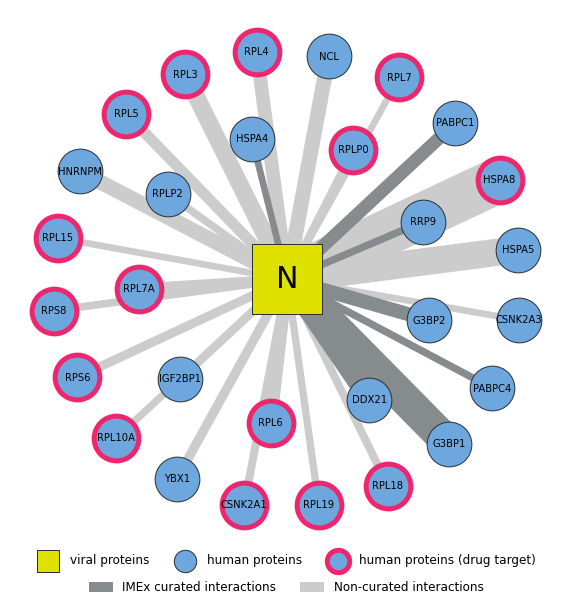

In [36]:
width = 10
height = width
fig, ax = plt.subplots(figsize=(width, height))

pos = nx.kamada_kawai_layout(ppi_network)

# Plot bait.
nodes_sars_cov_2 = nx.draw_networkx_nodes(
    ppi_network, pos, node_size=5000, nodelist=[bait], node_color='#DEE000',
    node_shape='s', edgecolors='#2a3135', ax=ax)
# Plot preys.
nodelist_prey_human = ppis_filtered_bait['PreyGene'].unique()
# Preys that are drug targets.
nodelist_prey_human_drugs = ppis_filtered_bait[
    ppis_filtered_bait['is_drug_target']]['PreyGene'].unique()
nodes_human_drug = nx.draw_networkx_nodes(
    ppi_network, pos, node_size=2000, nodelist=nodelist_prey_human_drugs,
    node_color='#6DA7DE', node_shape='o', linewidths=5, edgecolors='#EE266D',
    ax=ax)
# Preys that aren't drug targets.
nodelist_prey_human_nodrugs = ppis_filtered_bait[
    ~ppis_filtered_bait['is_drug_target']]['PreyGene'].unique()
nodes_human_nodrug = nx.draw_networkx_nodes(
    ppi_network, pos, node_size=2000, nodelist=nodelist_prey_human_nodrugs,
    node_color='#6DA7DE', node_shape='o', edgecolors='#2A3135', ax=ax)

# Plot gene names.
nx.draw_networkx_labels(ppi_network, pos, {bait: bait}, font_size=30)
nx.draw_networkx_labels(
    ppi_network, pos, {prey: prey for prey in pos.keys() if prey != bait},
    font_size=10)

# Plot edges.
# Non-confirmed interactions.
edgelist_remaining = list(
    ppis_filtered_bait[~ppis_filtered_bait['is_curated']]
    [['Bait', 'PreyGene']].itertuples(index=False))
edges_remaining = nx.draw_networkx_edges(
    ppi_network, pos, edgelist_remaining, edge_color='#CCCCCC',
    width=[ppi_network.edges[bait, prey]['AvgSpec']
           for bait, prey in edgelist_remaining])
# IMEx curated interactions.
edgelist_curated = list(
    ppis_filtered_bait[ppis_filtered_bait['is_curated']]
    [['Bait', 'PreyGene']].itertuples(index=False))
edges_curated = nx.draw_networkx_edges(
    ppi_network, pos, edgelist_curated, edge_color='#868B8E',
    width=[ppi_network.edges[bait, prey]['AvgSpec']
           for bait, prey in edgelist_curated])

# Adjust margins.
x_values, y_values = zip(*pos.values())
x_min, x_max = min(x_values), max(x_values)
x_margin = (x_max - x_min) * 0.1
ax.set_xlim(x_min - x_margin, x_max + x_margin)
y_min, y_max = min(y_values), max(y_values)
y_margin = (y_max - y_min) * 0.1
ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Node legend.
node_legend = ax.legend(
    [nodes_sars_cov_2, nodes_human_nodrug, nodes_human_drug],
    ['viral proteins', 'human proteins', 'human proteins (drug target)'],
    loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=3,
    fontsize='large', markerscale=0.5, frameon=False)
node_legend.legendHandles[0]._sizes = node_legend.legendHandles[1]._sizes
ax.add_artist(node_legend)
# Edge legend.
edge_legend = ax.legend(
    [edges_curated, edges_remaining],
    ['IMEx curated interactions', 'Non-curated interactions'],
    loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2,
    fontsize='large', markerscale=0.5, frameon=False)
for line in edge_legend.get_lines():
    line.set_linewidth(10)

sns.despine(left=True, bottom=True)

plt.savefig('ppi_network.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()